<a href="https://colab.research.google.com/github/Nihadkaipalli/Predictive-Modeling-for-Asteroid-and-Interstellar-Object-Collision-Risk-Using-Machine-Learning/blob/main/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Install Necessary Libraries**

In [14]:
!pip install dash pandas numpy matplotlib seaborn scikit-learn tensorflow

In [15]:
# Import necessary libraries
# Data Handling
import pandas as pd
import numpy as np

# Preprocessing and Scaling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Model Training and Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Monte Carlo Simulation
from scipy.stats import norm

# Custom Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Dashboard for Visualization
from dash import Dash, dcc, html
import plotly.express as px

# Email Alerts
import smtplib


# **2. Load and Preprocess Dataset**

In [27]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##2.1 Load Dataset

In [36]:
# Load the dataset from Google Drive
file_path = '/content/drive/My Drive/Asteroid Collision Dataset.csv'
df = pd.read_csv(file_path, low_memory=False)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [30]:
print(df.columns)

Index(['spkid', 'full_name', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'n',
       'tp', 'per_y', 'moid', 'moid_ld', 'moid_jup', 't_jup', 'sigma_e',
       'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma',
       'sigma_tp', 'sigma_per', 'class', 'condition_code', 'H', 'G',
       'diameter', 'extent', 'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR',
       'spec_B', 'H_sigma', 'diameter_sigma', 'neo', 'pha', 'orbit_id',
       'epoch_mjd', 'epoch_cal', 'equinox', 'ad', 'tp_cal', 'per', 'sigma_ad',
       'sigma_n', 'data_arc', 'first_obs', 'last_obs', 'n_obs_used', 'rms',
       'two_body', 'A1_sigma', 'A2_sigma', 'A3_sigma', 'DT_sigma'],
      dtype='object')


##2.2 Handling missing values

In [31]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
df[['H', 'diameter', 'albedo', 'rot_per']] = imputer.fit_transform(df[['H', 'diameter', 'albedo', 'rot_per']])

##2.3 Normalizing features

In [32]:
# Normalize relevant columns
scaler = StandardScaler()
df[['e', 'a', 'q', 'i', 'om', 'w', 'ma', 'n']] = scaler.fit_transform(df[['e', 'a', 'q', 'i', 'om', 'w', 'ma', 'n']])

##2.4 Create Target and Encode Features

In [37]:
# Convert 'pha' to binary
df['pha'] = df['pha'].apply(lambda x: 1 if x == 'Y' else 0)

# One-hot encode 'class' column
df = pd.get_dummies(df, columns=['class'], drop_first=True)

In [39]:
print(df.columns)

Index(['spkid', 'full_name', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'n',
       'tp', 'per_y', 'moid', 'moid_ld', 'moid_jup', 't_jup', 'sigma_e',
       'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma',
       'sigma_tp', 'sigma_per', 'condition_code', 'H', 'G', 'diameter',
       'extent', 'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B',
       'H_sigma', 'diameter_sigma', 'neo', 'pha', 'orbit_id', 'epoch_mjd',
       'epoch_cal', 'equinox', 'ad', 'tp_cal', 'per', 'sigma_ad', 'sigma_n',
       'data_arc', 'first_obs', 'last_obs', 'n_obs_used', 'rms', 'two_body',
       'A1_sigma', 'A2_sigma', 'A3_sigma', 'DT_sigma', 'class_APO',
       'class_ATE', 'class_HYA', 'class_IEO', 'class_IMB', 'class_MBA',
       'class_MCA', 'aphelion', 'perihelion_ratio'],
      dtype='object')


#**3. Feature Engineering**

##3.1 Derived Features

In [38]:
# Add derived features
df['aphelion'] = df['a'] * (1 + df['e'])
df['perihelion_ratio'] = df['q'] / df['a']

##3.2 Gravitational Influence

In [40]:
# Constants
G = 6.674e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_sun = 1.989e30  # Mass of the Sun (kg)
M_jupiter = 1.898e27  # Mass of Jupiter (kg)
M_earth = 5.972e24  # Mass of Earth (kg)
AU_to_m = 1.496e11  # Conversion from AU to meters
asteroid_density = 2500  # Average asteroid density (kg/m^3)

# Function to calculate asteroid mass
def calculate_asteroid_mass(diameter_km):
    radius_m = (diameter_km * 1000) / 2  # Convert km to meters
    volume = (4 / 3) * np.pi * radius_m**3
    return volume * asteroid_density

# Function to calculate gravitational force
def gravitational_force(mass_asteroid, mass_body, distance_au):
    distance_m = distance_au * AU_to_m  # Convert AU to meters
    return (G * mass_asteroid * mass_body) / (distance_m**2)

# Function to calculate total gravitational influence
def total_gravitational_influence(row):
    mass_asteroid = calculate_asteroid_mass(row['diameter'])
    sun_force = gravitational_force(mass_asteroid, M_sun, row['a'])
    jupiter_force = gravitational_force(mass_asteroid, M_jupiter, abs(row['a'] - 5.2))
    earth_force = gravitational_force(mass_asteroid, M_earth, abs(row['a'] - 1))
    return sun_force + jupiter_force + earth_force

# Apply to dataset
df['gravitational_influence'] = df.apply(total_gravitational_influence, axis=1)

#**4. Exploratory Data Analysis (EDA)**

##4.1 Visualize Gravitational Influence

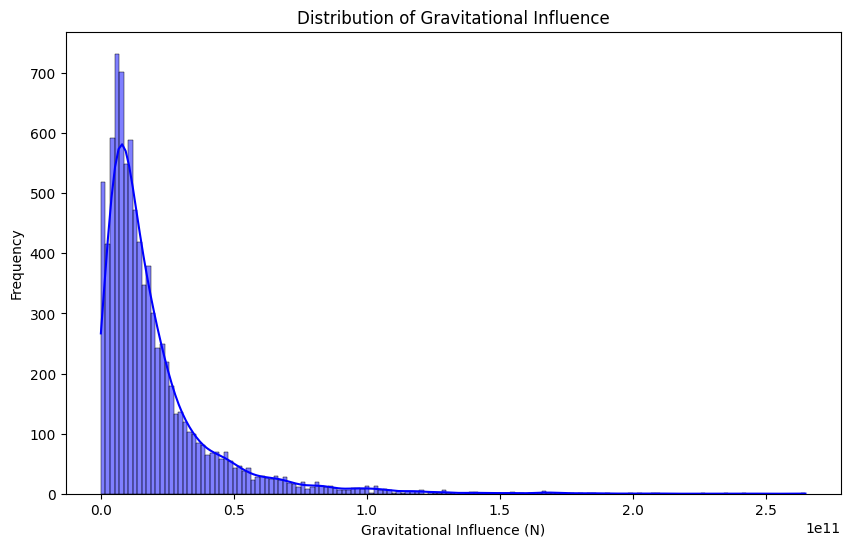

In [41]:
# Plot distribution of gravitational influence
plt.figure(figsize=(10, 6))
sns.histplot(df['gravitational_influence'], kde=True, color='blue')
plt.title("Distribution of Gravitational Influence")
plt.xlabel("Gravitational Influence (N)")
plt.ylabel("Frequency")
plt.show()